In [1]:
import pandas as pd
import numpy as np

## 4.1.3 Thought experiment

In [2]:
topic = {}
tfidf = dict(list(zip('cat dog apple lion NYC love'.split(), np.random.rand(6))))
topic['pet'] = (.3 * tfidf['cat'] + .3 * tfidf['dog'] + 0 * tfidf['apple']
                + 0 * tfidf['lion'] - .2 * tfidf['NYC'] + .2 * tfidf['love'])
topic['animal'] = (.1 * tfidf['cat'] + .1 * tfidf['dog'] - .1 * tfidf['apple']
                   + .5 * tfidf['lion'] + .1 * tfidf['NYC'] - .1 * tfidf['love'])
topic['city'] = (0 * tfidf['cat'] - .1 * tfidf['dog'] + .2 * tfidf['apple']
                 - .1 * tfidf['lion'] + .5 * tfidf['NYC'] + .1 * tfidf['love'])


In [3]:
tfidf

{'cat': 0.34877095731191854,
 'dog': 0.3291225016687306,
 'apple': 0.1976317267640031,
 'lion': 0.9415194380646533,
 'NYC': 0.9327241568469717,
 'love': 0.9661496766140836}

In [4]:
topic

{'pet': 0.2100531416476171,
 'animal': 0.5154433402772802,
 'city': 0.4754391974643564}

In [8]:
word_vector = {}
word_vector['cat'] = .3 * topic['pet'] + .1 * topic['animal'] + 0 * topic['city']
word_vector['dog'] = .3 * topic['pet'] + .1 * topic['animal'] - .1 * topic['city']
word_vector['apple'] = 0 * topic['pet'] - .1 * topic['animal'] + .2 * topic['city']
word_vector['lion'] = 0 * topic['pet'] + .5 * topic['animal'] - .1 * topic['city']
word_vector['NYC'] = -.2 * topic['pet'] + .1 * topic['animal'] + .5 * topic['city']
word_vector['love'] = .2 * topic['pet'] - .1 * topic['animal'] + .1 * topic['city']

In [9]:
word_vector

{'cat': 0.19919446227030893,
 'dog': 0.151789553594668,
 'apple': 0.06417679396102252,
 'lion': 0.10576020827565577,
 'NYC': 0.15528327418176427,
 'love': 0.12914617787208132}

# 4.1.5 An LDA classifier

In [5]:
sms = pd.read_csv('/Users/yeabinmoon/Documents/ibs_course/BUS243_NLP/nlpia-master/src/nlpia/data/sms-spam.csv',
index_col=0)

In [7]:
index = ['sms{}{}'.format(i, '!'*j) for (i,j) in zip(range(len(sms)), sms.spam)]
sms = pd.DataFrame(sms.values, columns=sms.columns, index=index)

In [8]:
sms.head()

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf_model.fit_transform(raw_documents=sms.text).toarray()
tfidf_docs.shape

(4837, 9232)

In [71]:
sms.spam.sum()

638

In [72]:
mask = sms.spam.astype(bool).values 

In [73]:
spam_centroid = tfidf_docs[mask].mean(axis=0)
ham_centroid = tfidf_docs[~mask].mean(axis=0)

In [74]:
len(spam_centroid)

9232

In [75]:
len(ham_centroid)

9232

In [76]:
print(spam_centroid.round(2))
print(ham_centroid.round(2))

[0.06 0.   0.   ... 0.   0.   0.  ]
[0.02 0.01 0.   ... 0.   0.   0.  ]


In [77]:
spam_centroid - ham_centroid

array([ 4.39266024e-02, -1.92685506e-03,  3.84287194e-04, ...,
       -6.31869803e-05, -6.31869803e-05, -6.31869803e-05])

In [78]:
spamminess_score = tfidf_docs.dot(spam_centroid - ham_centroid)

In [79]:
spamminess_score.round(2)

array([-0.01, -0.02,  0.04, ..., -0.01, -0.  ,  0.  ])

In [80]:
from sklearn.preprocessing import MinMaxScaler
sms['lda_score'] = MinMaxScaler().fit_transform(spamminess_score.reshape(-1,1))
sms['lda_predict'] = (sms.lda_score > .5).astype(int)

In [81]:
sms

,spam,text,lda_score,lda_predict
0,0,"Go until jurong point, crazy.. Available only ...",0.227478,0
1,0,Ok lar... Joking wif u oni...,0.177888,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,0.718785,1
3,0,U dun say so early hor... U c already then say...,0.184565,0
4,0,"Nah I don't think he goes to usf, he lives aro...",0.286944,0
...,...,...,...,...
4832,1,This is the 2nd time we have tried 2 contact u...,0.850649,1
4833,0,Will ü b going to esplanade fr home?,0.292753,0
4834,0,"Pity, * was in mood for that. So...any other s...",0.269454,0
4835,0,The guy did some bitching but I acted like i'd...,0.331306,0


In [82]:
(1. - (sms.spam - sms.lda_predict).abs().sum() / len(sms)).round(3)

0.977

### 2-dimensional plot

Text(0, 0.5, ' y')

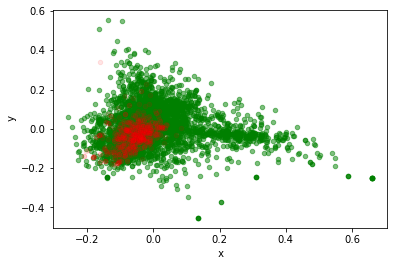

In [83]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn
pca_model = PCA(n_components=3)
tfidf_docs_3d = pca_model.fit_transform(tfidf_docs)
df = pd.DataFrame(tfidf_docs_3d)
ax = df[~mask].plot(x=0, y=1, kind='scatter', alpha=.5, c='green')
df[mask].plot(x=0, y=1, ax=ax, alpha=.1, kind='scatter', c='red')
plt.xlabel(' x')
plt.ylabel(' y')

### 3-dimensional plot

In [84]:
import plotly as py
spam_trace = dict(
        x=df[0][mask], y=df[1][mask], z=df[2][mask],
        type="scatter3d", mode='markers',
        marker= dict(size=3, color='red', line=dict(width=0)) 
    )
ham_trace = dict(
        x=df[0][~mask], y=df[1][~mask], z=df[2][~mask],
        type="scatter3d", mode='markers',
        marker= dict(size=3, color='green', line=dict(width=0)) 
    )
fig = dict(data=[ham_trace, spam_trace], layout={'title': 'LDA Spamminess Model'})
py.offline.plot(fig, filename='lda_spam_3d_scatter.html')

'lda_spam_3d_scatter.html'

# 4.3 Singular value decomposition

In [2]:
from nlpia.book.examples.ch04_catdog_lsa_sorted import lsa_models, prettify_tdm

2023-01-30 19:12:41.818328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.9/site-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/opt/anaconda3/lib/python3.9/site-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
/opt/anaconda3/lib/python3.9/site-packages/pugnlp/tutil.py:100: FutureWarning: The p

In [3]:
bow_svd, tfidf_svd = lsa_models()  

100%|██████████| 263/263 [00:00<00:00, 261398.57it/s]


In [4]:
prettify_tdm(**bow_svd)

,cat,dog,apple,lion,nyc,love,text
0,,,1,,1,,NYC is the Big Apple.
1,,,1,,1,,NYC is known as the Big Apple.
2,,,,,1,1,I love NYC!
3,,,1,,1,,I wore a hat to the Big Apple party in NYC.
4,,,1,,1,,Come to NYC. See the Big Apple!
5,,,1,,,,Manhattan is called the Big Apple.
6,1,,,,,,New York is a big city for a small cat.
7,1,,,1,,,"The lion, a big cat, is the king of the jungle."
8,1,,,,,1,I love my pet cat.
9,,,,,1,1,I love New York City (NYC).


In [7]:
tdm = bow_svd['tdm']

In [8]:
tdm

,0,1,2,3,4,5,6,7,8,9,10
cat,0,0,0,0,0,0,1,1,1,0,1
dog,0,0,0,0,0,0,0,0,0,0,1
apple,1,1,0,1,1,1,0,0,0,0,0
lion,0,0,0,0,0,0,0,1,0,0,0
nyc,1,1,1,1,1,0,0,0,0,1,0
love,0,0,1,0,0,0,0,0,1,1,0


In [9]:
import numpy as np
import pandas as pd

U, s, Vt = np.linalg.svd(tdm)

In [10]:
pd.DataFrame(U, index = tdm.index).round(2)

,0,1,2,3,4,5
cat,0.04,-0.83,-0.38,-0.00,0.11,0.38
dog,0.00,-0.21,-0.18,-0.71,-0.39,-0.52
apple,0.62,0.21,-0.51,0.00,0.49,-0.27
lion,0.00,-0.21,-0.18,0.71,-0.39,-0.52
nyc,0.75,0.00,0.24,-0.00,-0.52,0.32
love,0.22,-0.42,0.69,0.00,0.41,-0.37


In [12]:
U.round(2)

array([[ 0.04, -0.83, -0.38, -0.  ,  0.11,  0.38],
       [ 0.  , -0.21, -0.18, -0.71, -0.39, -0.52],
       [ 0.62,  0.21, -0.51,  0.  ,  0.49, -0.27],
       [ 0.  , -0.21, -0.18,  0.71, -0.39, -0.52],
       [ 0.75,  0.  ,  0.24, -0.  , -0.52,  0.32],
       [ 0.22, -0.42,  0.69,  0.  ,  0.41, -0.37]])

In [16]:
Vt.round(2)

array([[ 0.44,  0.44,  0.31,  0.44,  0.44,  0.2 ,  0.01,  0.01,  0.08,
         0.31,  0.01],
       [ 0.09,  0.09, -0.19,  0.09,  0.09,  0.09, -0.37, -0.47, -0.56,
        -0.19, -0.47],
       [-0.16, -0.16,  0.52, -0.16, -0.16, -0.29, -0.22, -0.32,  0.17,
         0.52, -0.32],
       [-0.  , -0.  , -0.  , -0.  , -0.  ,  0.  , -0.  ,  0.71,  0.  ,
        -0.  , -0.71],
       [-0.04, -0.04, -0.14, -0.04, -0.04,  0.58,  0.13, -0.33,  0.62,
        -0.14, -0.33],
       [ 0.09,  0.09, -0.1 ,  0.09,  0.09, -0.51,  0.73, -0.27,  0.01,
        -0.1 , -0.27],
       [-0.42, -0.44,  0.09,  0.57,  0.01,  0.29,  0.29,  0.  , -0.29,
         0.2 ,  0.  ],
       [-0.33,  0.56,  0.16,  0.41, -0.54, -0.1 , -0.1 , -0.  ,  0.1 ,
        -0.25,  0.  ],
       [-0.49,  0.03, -0.27,  0.19,  0.59, -0.31, -0.31,  0.  ,  0.31,
        -0.05,  0.  ],
       [-0.11,  0.32, -0.61, -0.08, -0.19,  0.07,  0.07, -0.  , -0.07,
         0.68, -0.  ],
       [-0.47,  0.39,  0.3 , -0.49,  0.3 ,  0.26,  0.26,  0.

In [20]:
tdm.shape

(6, 11)

In [21]:
print(U.shape, len(s), Vt.shape)

(6, 6) 6 (11, 11)


In [24]:
S = np.zeros((len(U),len(Vt)))

In [26]:
np.fill_diagonal(S,s)
pd.DataFrame(S).round(1)

,0,1,2,3,4,5,6,7,8,9,10
0,3.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


In [27]:
S.shape

(6, 11)

In [28]:
pd.DataFrame(Vt).round(2)

,0,1,2,3,4,5,6,7,8,9,10
0,0.44,0.44,0.31,0.44,0.44,0.20,0.01,0.01,0.08,0.31,0.01
1,0.09,0.09,-0.19,0.09,0.09,0.09,-0.37,-0.47,-0.56,-0.19,-0.47
2,-0.16,-0.16,0.52,-0.16,-0.16,-0.29,-0.22,-0.32,0.17,0.52,-0.32
3,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.71,0.00,-0.00,-0.71
4,-0.04,-0.04,-0.14,-0.04,-0.04,0.58,0.13,-0.33,0.62,-0.14,-0.33
5,0.09,0.09,-0.10,0.09,0.09,-0.51,0.73,-0.27,0.01,-0.10,-0.27
6,-0.42,-0.44,0.09,0.57,0.01,0.29,0.29,0.00,-0.29,0.20,0.00
7,-0.33,0.56,0.16,0.41,-0.54,-0.10,-0.10,-0.00,0.10,-0.25,0.00
8,-0.49,0.03,-0.27,0.19,0.59,-0.31,-0.31,0.00,0.31,-0.05,0.00
9,-0.11,0.32,-0.61,-0.08,-0.19,0.07,0.07,-0.00,-0.07,0.68,-0.00


In [34]:
err = [0]
for numdim in range(len(s), 0, -1):
    S[numdim - 1, numdim - 1] = 0
    reconstructed_tdm = U.dot(S).dot(Vt)
    err.append(np.sqrt(((reconstructed_tdm - tdm).values.flatten() ** 2).sum()/ np.product(tdm.shape)))
np.array(err).round(2)

array([0.  , 0.06, 0.12, 0.17, 0.28, 0.39, 0.55])

In [35]:
# using tfidf tdm
tdm = tfidf_svd['tdm']
U, s, Vt = np.linalg.svd(tdm)
S = np.zeros((len(U), len(Vt)))
np.fill_diagonal(S, s)
err2 = [0]
for numdim in range(len(s), 0, -1):
    S[numdim - 1, numdim - 1] = 0
    reconstructed_tdm = U.dot(S).dot(Vt)
    err2.append(np.sqrt(((reconstructed_tdm - tdm).values.flatten() ** 2).sum() / np.product(tdm.shape)))
np.array(err2).round(2)

array([0.  , 0.07, 0.11, 0.15, 0.23, 0.3 , 0.41])

# 4.4 Principal component analysis

              x         y         z
46533  0.015047 -0.043478 -0.002522
33564 -0.007327  0.062038  0.049706
40075 -0.026133  0.071840  0.061419
4929  -0.011138 -0.057819 -0.002953
25228 -0.004825 -0.053159  0.029444


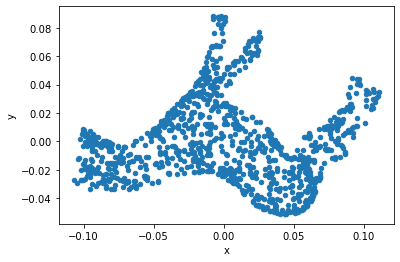

In [39]:
pd.set_option('display.max_columns', 6)
from sklearn.decomposition import PCA
import seaborn
import matplotlib.pyplot as plt
from nlpia.data.loaders import get_data

df = get_data('pointcloud').sample(1000)
print(df.head())
pca = PCA(n_components=2)
df2d = pd.DataFrame(pca.fit_transform(df), columns=list('xy'))
df2d.plot(kind='scatter', x='x', y='y')
plt.show()

## 4.4.2 Stop horsing around and get back to NLP

In [1]:
import pandas as pd
pd.options.display.width = 120 

sms = pd.read_csv('/Users/yeabinmoon/Documents/ibs_course/BUS243_NLP/nlpia-master/src/nlpia/data/sms-spam.csv',
index_col=0)
index = ['sms{}{}'.format(i, '!'*j) for (i,j) in zip(range(len(sms)), sms.spam)]


In [2]:
sms.index = index

In [3]:
sms

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
sms4832!,1,This is the 2nd time we have tried 2 contact u...
sms4833,0,Will ü b going to esplanade fr home?
sms4834,0,"Pity, * was in mood for that. So...any other s..."
sms4835,0,The guy did some bitching but I acted like i'd...


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

In [5]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=sms.text).toarray()

In [6]:
tfidf_docs.shape

(4837, 9232)

In [7]:
len(tfidf.vocabulary_)

9232

In [47]:
tfidf_docs = pd.DataFrame(tfidf_docs)

In [8]:
# centering
tfidf_docs = tfidf_docs - tfidf_docs.mean()

In [9]:
sms.spam.sum()     

638

In [10]:
from sklearn.decomposition import PCA

In [11]:
pca = PCA(n_components=16)
pca_topic_vectors = pca.fit_transform(tfidf_docs)

In [13]:
columns = ['topic{}'.format(i) for i in range(pca.n_components)]
pca_topic_vectors = pd.DataFrame(pca_topic_vectors, columns=columns, index=index)

In [14]:
pca_topic_vectors.round(3).head(6)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,0.039,-0.066,0.009,-0.083,0.009,-0.007,-0.034,-0.017,-0.024,0.027
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,0.023,0.065,0.024,-0.026,-0.008,0.038,-0.036,0.011,0.056,-0.042
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,-0.000,-0.001,-0.055,0.052,0.129,0.020,-0.038,0.011,-0.045,0.046
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,-0.166,-0.074,0.064,-0.111,0.014,0.026,-0.074,0.019,0.033,-0.068
sms4,0.002,0.031,0.038,0.034,-0.075,-0.093,-0.044,0.062,-0.044,0.029,0.027,-0.006,0.008,0.048,-0.081,-0.028
sms5!,-0.016,0.058,0.014,-0.006,0.122,-0.040,0.005,0.166,-0.022,0.066,0.048,0.051,0.071,0.029,0.006,0.032


In [17]:
# What is the following matrix?
print(pca.components_.shape)
pca.components_

(16, 9232)


array([[-0.07109825,  0.00818014, -0.00121146, ...,  0.00057176,
         0.00057176,  0.00057176],
       [ 0.06318977,  0.00777061,  0.00026513, ...,  0.00102076,
         0.00102076,  0.00102076],
       [ 0.07097967,  0.02684327,  0.00013358, ..., -0.00095356,
        -0.00095356, -0.00095356],
       ...,
       [-0.06491723, -0.02701747,  0.00351994, ...,  0.00110426,
         0.00110426,  0.00110426],
       [-0.01900378, -0.01108555,  0.00094728, ...,  0.00086274,
         0.00086274,  0.00086274],
       [ 0.02132156, -0.02053435,  0.00013996, ..., -0.00034661,
        -0.00034661, -0.00034661]])

In [18]:
tfidf.vocabulary_

{'go': 3807,
 'until': 8487,
 'jurong': 4675,
 'point': 6296,
 ',': 13,
 'crazy': 2549,
 '..': 21,
 'available': 1531,
 'only': 5910,
 'in': 4396,
 'bugis': 1973,
 'n': 5594,
 'great': 3894,
 'world': 8977,
 'la': 4811,
 'e': 3056,
 'buffet': 1971,
 '...': 25,
 'cine': 2277,
 'there': 8071,
 'got': 3855,
 'amore': 1296,
 'wat': 8736,
 'ok': 5874,
 'lar': 4848,
 'joking': 4642,
 'wif': 8875,
 'u': 8395,
 'oni': 5906,
 'free': 3604,
 'entry': 3195,
 '2': 471,
 'a': 1054,
 'wkly': 8933,
 'comp': 2386,
 'to': 8192,
 'win': 8890,
 'fa': 3328,
 'cup': 2608,
 'final': 3450,
 'tkts': 8180,
 '21st': 497,
 'may': 5272,
 '2005': 487,
 '.': 15,
 'text': 8020,
 '87121': 948,
 'receive': 6688,
 'question': 6574,
 '(': 9,
 'std': 7651,
 'txt': 8379,
 'rate': 6628,
 ')': 10,
 't': 7889,
 '&': 7,
 "c's": 2020,
 'apply': 1383,
 '08452810075': 115,
 'over': 6003,
 '18': 438,
 "'": 8,
 's': 6959,
 'dun': 3041,
 'say': 7034,
 'so': 7438,
 'early': 3069,
 'hor': 4207,
 'c': 2019,
 'already': 1268,
 'then': 

In [19]:
column_nums, terms = zip(*sorted(zip(tfidf.vocabulary_.values(), tfidf.vocabulary_.keys()))) 

In [20]:
terms

('!',
 '"',
 '#',
 '#150',
 '#5000',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '. .',
 '. . .',
 '. . . .',
 '. . . . .',
 '. ..',
 '..',
 '.. .',
 '.. . . .',
 '.. ... ...',
 '...',
 '... . . . .',
 '/',
 '0',
 '00',
 '00870405040',
 '0089',
 '01',
 '0121 2025050',
 '01223585236',
 '01223585334',
 '01256987',
 '02',
 '02/06',
 '02/09',
 '0207 153 9153',
 '0207 153 9996',
 '0207-083-6089',
 '02072069400',
 '02073162414',
 '02085076972',
 '03',
 '03530150',
 '04',
 '04/09',
 '05',
 '050703',
 '06',
 '06.05',
 '06/11',
 '07/11',
 '07008009200',
 '07046744435',
 '07090201529',
 '07090298926',
 '07099833605',
 '07123456789',
 '07732584351',
 '07734396839',
 '07742676969',
 '07753741225',
 '0776xxxxxxx',
 '07786200117',
 '077xxx',
 '078',
 '07801543489',
 '07808',
 '07808247860',
 '07808726822',
 '07815296484',
 '07821230901',
 '078498',
 '07880867867',
 '0789xxxxxxx',
 '07946746291',
 '0796xxxxxx',
 '07973788240',
 '07xxxxxxxxx',
 '08',
 '0800',
 '0800 0721072',
 '

In [21]:
weights = pd.DataFrame(pca.components_, columns=terms, index=['topic{}'.format(i) for i in range(16)])

In [22]:
pd.options.display.max_columns = 8
weights.round(3)

,!,"""",#,#150,...,…,┾,〨ud,鈥
topic0,-0.071,0.008,-0.001,-0.000,...,-0.002,0.001,0.001,0.001
topic1,0.063,0.008,0.000,-0.000,...,0.003,0.001,0.001,0.001
topic2,0.071,0.027,0.000,0.001,...,0.002,-0.001,-0.001,-0.001
topic3,-0.059,-0.032,-0.001,-0.000,...,0.001,0.001,0.001,0.001
topic4,0.380,-0.008,0.001,0.001,...,0.002,0.001,0.001,0.001
topic5,-0.266,-0.053,0.002,0.000,...,-0.003,-0.001,-0.001,-0.001
topic6,-0.109,0.019,-0.001,-0.000,...,-0.001,0.000,0.000,0.000
topic7,0.158,0.034,0.000,-0.000,...,0.006,-0.000,-0.000,-0.000
topic8,0.337,0.025,-0.002,0.000,...,-0.004,0.000,0.000,0.000
topic9,0.086,-0.116,-0.000,0.000,...,-0.004,-0.000,-0.000,-0.000


In [23]:
pd.options.display.max_columns = 12
deals = weights['! ;) :) half off free crazy deal only $ 80 %'.split()].round(3) * 100
deals

,!,;),:),half,off,free,crazy,deal,only,$,80,%
topic0,-7.1,0.1,-0.5,-0.0,-0.4,-2.0,-0.0,-0.1,-2.2,0.3,-0.0,-0.0
topic1,6.3,0.0,7.4,0.1,0.4,-2.3,-0.2,-0.1,-3.8,-0.1,-0.0,-0.2
topic2,7.1,0.2,-0.1,0.0,0.3,4.4,0.1,-0.1,0.7,0.0,0.0,0.1
topic3,-5.9,-0.3,-7.0,0.2,0.3,-0.2,0.0,0.1,-2.3,0.1,-0.1,-0.3
topic4,38.0,-0.1,-12.4,-0.1,-0.2,9.9,0.1,-0.2,3.0,0.3,0.1,-0.1
topic5,-26.6,0.1,-1.6,-0.3,-0.7,-1.4,-0.6,-0.2,-1.8,-0.9,0.0,0.0
topic6,-10.9,-0.5,19.8,-0.4,-0.9,-0.6,-0.2,-0.1,-1.4,-0.0,-0.0,-0.1
topic7,15.8,0.1,-17.7,0.8,0.8,-2.9,0.0,0.1,-1.9,-0.3,0.0,-0.1
topic8,33.7,0.1,5.0,-0.4,-0.5,0.2,-0.5,-0.4,3.2,-0.6,-0.0,-0.2
topic9,8.6,-0.3,16.8,1.4,-0.9,6.2,-0.4,-0.4,2.9,-0.4,-0.0,0.0


In [24]:
deals.T.sum()

topic0    -11.9
topic1      7.5
topic2     12.7
topic3    -15.4
topic4     38.3
topic5    -34.0
topic6      4.7
topic7     -5.3
topic8     39.6
topic9     33.5
topic10   -27.1
topic11    53.6
topic12    20.1
topic13    37.4
topic14    25.2
topic15     1.3
dtype: float64

## 4.4.4 Using truncated SVD for SMS message semantic analysis

In [25]:
from sklearn.decomposition import TruncatedSVD

In [26]:
svd = TruncatedSVD(n_components=16, n_iter=100)

In [29]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=sms.text).toarray()
tfidf_docs = pd.DataFrame(tfidf_docs)
tfidf_docs = tfidf_docs - tfidf_docs.mean()

In [31]:
svd_topic_vectors = svd.fit_transform(tfidf_docs.values)

In [32]:
svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns, index = index)

In [33]:
svd_topic_vectors.round(3).head(6)

,topic0,topic1,topic2,topic3,topic4,topic5,...,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,...,0.007,-0.007,0.002,-0.036,-0.014,0.037
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,...,-0.004,0.036,0.043,-0.021,0.051,-0.042
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,...,0.125,0.023,0.026,-0.020,-0.042,0.052
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,...,0.022,0.023,0.073,-0.046,0.022,-0.070
sms4,0.002,0.031,0.038,0.034,-0.075,-0.093,...,0.028,-0.009,0.027,0.034,-0.083,-0.021
sms5!,-0.016,0.059,0.014,-0.006,0.122,-0.040,...,0.041,0.055,-0.037,0.075,-0.001,0.020


## 4.4.5 How well does LSA work for spam classification?

In [35]:
import numpy as np

In [36]:
svd_topic_vectors = (svd_topic_vectors.T / np.linalg.norm(svd_topic_vectors, axis=1)).T  

In [37]:
svd_topic_vectors.iloc[:10].dot(svd_topic_vectors.iloc[:10].T).round(1)

,sms0,sms1,sms2!,sms3,sms4,sms5!,sms6,sms7,sms8!,sms9!
sms0,1.0,0.6,-0.1,0.6,-0.0,-0.3,-0.3,-0.1,-0.3,-0.3
sms1,0.6,1.0,-0.2,0.8,-0.2,0.0,-0.2,-0.2,-0.1,-0.1
sms2!,-0.1,-0.2,1.0,-0.2,0.1,0.4,0.0,0.3,0.5,0.4
sms3,0.6,0.8,-0.2,1.0,-0.2,-0.3,-0.1,-0.3,-0.2,-0.1
sms4,-0.0,-0.2,0.1,-0.2,1.0,0.2,0.0,0.1,-0.4,-0.2
sms5!,-0.3,0.0,0.4,-0.3,0.2,1.0,-0.1,0.1,0.3,0.4
sms6,-0.3,-0.2,0.0,-0.1,0.0,-0.1,1.0,0.1,-0.2,-0.2
sms7,-0.1,-0.2,0.3,-0.3,0.1,0.1,0.1,1.0,0.1,0.4
sms8!,-0.3,-0.1,0.5,-0.2,-0.4,0.3,-0.2,0.1,1.0,0.3
sms9!,-0.3,-0.1,0.4,-0.1,-0.2,0.4,-0.2,0.4,0.3,1.0


# 4.5 Latent Dirichlet allocation (LDiA)

In [38]:
sms.head(6)

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
sms5!,1,FreeMsg Hey there darling it's been 3 week's n...


In [39]:
total_corpus_len = 0
for document_text in sms.text:
    total_corpus_len += len(casual_tokenize(document_text))
print(total_corpus_len)

103260


In [40]:
mean_document_len = total_corpus_len / len(sms)
round(mean_document_len, 2)

21.35

In [41]:
# or, in a one-liner
sum([len(casual_tokenize(t)) for t in sms.text]) * 1. / len(sms.text)

21.34794293983874

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import casual_tokenize

In [43]:
np.random.seed(42)
counter = CountVectorizer(tokenizer=casual_tokenize)

In [44]:
bow_docs = pd.DataFrame(counter.fit_transform(raw_documents=sms.text).toarray(), index = index)

In [45]:
bow_docs

,0,1,2,3,4,5,...,9226,9227,9228,9229,9230,9231
sms0,0,0,0,0,0,0,...,0,0,0,0,0,0
sms1,0,0,0,0,0,0,...,0,0,0,0,0,0
sms2!,0,0,0,0,0,0,...,0,0,0,0,0,0
sms3,0,0,0,0,0,0,...,0,0,0,0,0,0
sms4,0,0,0,0,0,0,...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
sms4832!,1,0,0,0,0,0,...,0,0,0,0,0,0
sms4833,0,0,0,0,0,0,...,0,0,0,0,0,0
sms4834,0,0,0,0,0,0,...,0,0,0,0,0,0
sms4835,0,0,0,0,0,0,...,0,0,0,0,0,0


In [46]:
column_nums, terms = zip(*sorted(zip(counter.vocabulary_.values(),counter.vocabulary_.keys())))
bow_docs.columns = terms
bow_docs

,!,"""",#,#150,#5000,$,...,’,“,…,┾,〨ud,鈥
sms0,0,0,0,0,0,0,...,0,0,0,0,0,0
sms1,0,0,0,0,0,0,...,0,0,0,0,0,0
sms2!,0,0,0,0,0,0,...,0,0,0,0,0,0
sms3,0,0,0,0,0,0,...,0,0,0,0,0,0
sms4,0,0,0,0,0,0,...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
sms4832!,1,0,0,0,0,0,...,0,0,0,0,0,0
sms4833,0,0,0,0,0,0,...,0,0,0,0,0,0
sms4834,0,0,0,0,0,0,...,0,0,0,0,0,0
sms4835,0,0,0,0,0,0,...,0,0,0,0,0,0


In [47]:
sms.loc['sms0'].text

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [48]:
bow_docs.loc['sms0'][bow_docs.loc['sms0'] > 0]

,            1
..           1
...          2
amore        1
available    1
buffet       1
bugis        1
cine         1
crazy        1
e            1
go           1
got          1
great        1
in           1
jurong       1
la           1
n            1
only         1
point        1
there        1
until        1
wat          1
world        1
Name: sms0, dtype: int64

In [49]:
from sklearn.decomposition import LatentDirichletAllocation as LDiA
ldia = LDiA(n_components=16, learning_method='batch')

In [50]:
ldia = ldia.fit(bow_docs)

In [54]:
ldia.components_.shape

(16, 9232)

In [55]:
pd.set_option('display.width', 75)
components = pd.DataFrame(ldia.components_.T, index=terms, columns=columns)
components.round(2).head(5)

,topic0,topic1,topic2,topic3,topic4,topic5,...,topic10,topic11,topic12,topic13,topic14,topic15
!,20.03,20.44,0.85,52.68,0.06,204.72,...,134.04,38.21,100.30,135.82,481.08,5.19
"""",0.06,9.00,0.06,0.06,0.12,0.06,...,3.80,0.06,7.41,0.06,92.34,24.30
#,0.06,0.06,0.06,0.06,0.06,0.06,...,0.06,0.06,0.06,0.06,5.06,0.06
#150,0.06,1.06,0.06,0.06,0.06,0.06,...,0.06,0.06,0.06,0.06,0.06,0.06
#5000,3.06,0.06,0.06,0.06,0.06,0.06,...,0.06,0.06,0.06,0.06,0.06,0.06


In [56]:
components.topic3.sort_values(ascending=False)[:10]

to      174.492758
the     132.447021
and     103.139835
.        95.918658
your     64.338532
from     62.993171
for      59.914714
of       59.226303
free     59.122778
call     55.558074
Name: topic3, dtype: float64

In [57]:
ldia16_topic_vectors = ldia.transform(bow_docs)

In [58]:
ldia16_topic_vectors.shape

(4837, 16)

In [59]:
ldia16_topic_vectors = pd.DataFrame(ldia16_topic_vectors, index=index, columns=columns)

In [60]:
ldia16_topic_vectors

,topic0,topic1,topic2,topic3,topic4,topic5,...,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,...,0.002500,0.002500,0.444411,0.002500,0.002500,0.002500
sms1,0.006944,0.006944,0.006944,0.006944,0.139232,0.006944,...,0.006944,0.006944,0.006944,0.006944,0.006944,0.198444
sms2!,0.001563,0.001563,0.001563,0.001563,0.001563,0.664294,...,0.001563,0.001563,0.001563,0.001563,0.313831,0.001563
sms3,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,...,0.004464,0.004464,0.088968,0.004464,0.004464,0.004464
sms4,0.004167,0.004167,0.004167,0.004167,0.696919,0.004167,...,0.004167,0.004167,0.004167,0.004167,0.244747,0.004167
...,...,...,...,...,...,...,...,...,...,...,...,...,...
sms4832!,0.209387,0.001563,0.001563,0.001563,0.001563,0.183200,...,0.001563,0.001563,0.168072,0.001563,0.001563,0.420592
sms4833,0.006250,0.006250,0.354954,0.006250,0.006250,0.006250,...,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250
sms4834,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,...,0.003906,0.003906,0.003906,0.003906,0.941406,0.003906
sms4835,0.002315,0.002315,0.002315,0.446139,0.002315,0.002315,...,0.002315,0.240159,0.002315,0.002315,0.002315,0.002315


## 4.5.3 LDiA + LDA = spam classifier

In [62]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(ldia16_topic_vectors, sms.spam, test_size=0.5, random_state=271828)
lda = LDA(n_components=1)
lda = lda.fit(X_train, y_train)
sms['ldia16_spam'] = lda.predict(ldia16_topic_vectors)
round(float(lda.score(X_test, y_test)), 2)

0.92

In [52]:
ldia16_topic_vectors

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
sms0,0.002500,0.620075,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.344925,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500,0.002500
sms1,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944,0.781721,0.006944,0.006944,0.121056,0.006944,0.006944,0.006944,0.006944
sms2!,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.976562,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563
sms3,0.004464,0.004464,0.004464,0.004464,0.088350,0.004464,0.004464,0.004464,0.849150,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464
sms4,0.394632,0.004167,0.333172,0.004167,0.004167,0.004167,0.136218,0.004167,0.004167,0.004167,0.004167,0.004167,0.085978,0.004167,0.004167,0.004167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sms4832!,0.001563,0.001563,0.001563,0.927395,0.001563,0.001563,0.001563,0.001563,0.001563,0.050730,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563
sms4833,0.006250,0.006250,0.006250,0.006250,0.006250,0.589556,0.006250,0.006250,0.322944,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250
sms4834,0.003906,0.003906,0.494008,0.003906,0.003906,0.003906,0.003906,0.003906,0.354560,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,0.100650
sms4835,0.002315,0.002315,0.681962,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,0.285630,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315


In [64]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=sms.text).toarray()
tfidf_docs = tfidf_docs - tfidf_docs.mean(axis=0) 

X_train, X_test, y_train, y_test = train_test_split(tfidf_docs, sms.spam.values, test_size=0.5, random_state=271828)
lda = LDA(n_components=1)
lda = lda.fit(X_train, y_train)
print(round(float(lda.score(X_train, y_train)), 3))
print(round(float(lda.score(X_test, y_test)), 3))

1.0
0.748


## 4.5.4 A fairer comparison: 32 LDiA topics

In [65]:
ldia32 = LDiA(n_components=32, learning_method='batch')
ldia32 = ldia32.fit(bow_docs)
ldia32.components_.shape

(32, 9232)

In [66]:
ldia32_topic_vectors = ldia32.transform(bow_docs)
columns32 = ['topic{}'.format(i) for i in range(ldia32.n_components)]
ldia32_topic_vectors = pd.DataFrame(ldia32_topic_vectors, index=index, columns=columns32)
ldia32_topic_vectors.round(2).head()

,topic0,topic1,topic2,topic3,topic4,topic5,...,topic26,topic27,topic28,topic29,topic30,topic31
sms0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
sms1,0.0,0.89,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
sms2!,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
sms3,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
sms4,0.0,0.00,0.34,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
X_train, X_test, y_train, y_test = train_test_split(ldia32_topic_vectors, sms.spam, test_size=0.5, random_state=271828)
lda = LDA(n_components=1)
lda = lda.fit(X_train, y_train)
sms['ldia32_spam'] = lda.predict(ldia32_topic_vectors)

In [68]:
X_train.shape

(2418, 32)

In [69]:
round(float(lda.score(X_train, y_train)), 3)

0.885

In [70]:
round(float(lda.score(X_test, y_test)), 3)

0.902

In [71]:
import sklearn

In [72]:
sklearn.__file__

'/opt/anaconda3/lib/python3.9/site-packages/sklearn/__init__.py'

In [73]:
LDA??

Init signature:
LDA(
    solver='svd',
    shrinkage=None,
    priors=None,
    n_components=None,
    store_covariance=False,
    tol=0.0001,
    covariance_estimator=None,
)
Source:        
class LinearDiscriminantAnalysis(
    _ClassNamePrefixFeaturesOutMixin,
    LinearClassifierMixin,
    TransformerMixin,
    BaseEstimator,
):
    """Linear Discriminant Analysis.

    A classifier with a linear decision boundary, generated by fitting class
    conditional densities to the data and using Bayes' rule.

    The model fits a Gaussian density to each class, assuming that all classes
    share the same covariance matrix.

    The fitted model can also be used to reduce the dimensionality of the input
    by projecting it to the most discriminative directions, using the
    `transform` method.

    .. versionadded:: 0.17
       *LinearDiscriminantAnalysis*.

    Read more in the :ref:`User Guide <lda_qda>`.

    Parameters
    ----------
    solver : {'svd', 'lsqr', 'eigen'}, default='s